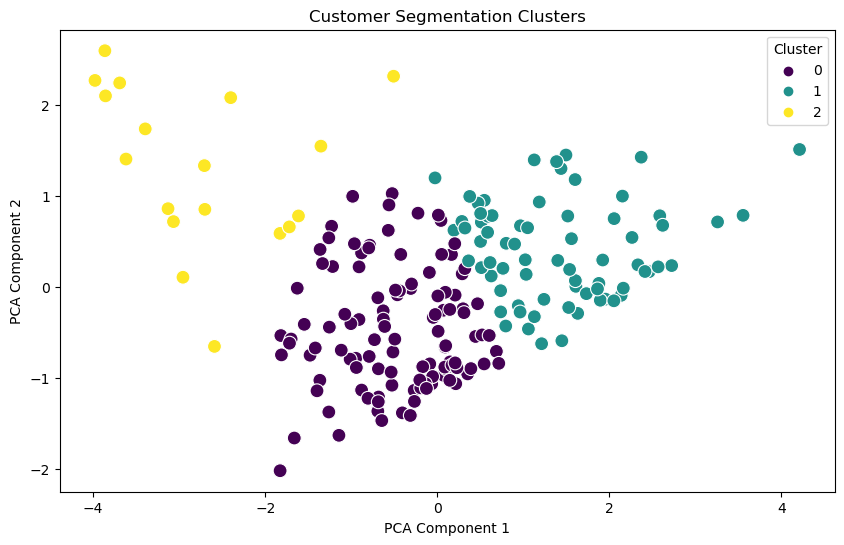

Optimal Clusters: 3
Davies-Bouldin Index: 0.880
Silhouette Score: 0.384


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

# Merge data on CustomerID
merged_df = transactions.merge(customers, on="CustomerID")

# Feature Engineering: Compute RFM values
rfm = merged_df.groupby("CustomerID").agg({
    "TransactionDate": lambda x: (pd.to_datetime('2025-01-01') - pd.to_datetime(x).max()).days,  # Recency
    "TransactionID": 'count',  # Frequency
    "TotalValue": 'sum'  # Monetary
}).rename(columns={"TransactionDate": "Recency", "TransactionID": "Frequency", "TotalValue": "Monetary"})

# Normalize the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Find optimal number of clusters using the Davies-Bouldin Index
db_scores = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled)
    db_scores.append(davies_bouldin_score(rfm_scaled, labels))
    silhouette_scores.append(silhouette_score(rfm_scaled, labels))

# Optimal number of clusters
optimal_k = k_range[np.argmin(db_scores)]
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Compute final DB Index and Silhouette Score
final_db_index = davies_bouldin_score(rfm_scaled, rfm['Cluster'])
final_silhouette_score = silhouette_score(rfm_scaled, rfm['Cluster'])

# PCA for Visualization
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)
rfm['PCA1'] = rfm_pca[:, 0]
rfm['PCA2'] = rfm_pca[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=rfm['PCA1'], y=rfm['PCA2'], hue=rfm['Cluster'], palette='viridis', s=100)
plt.title("Customer Segmentation Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Print DB Index and Silhouette Score
print(f"Optimal Clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {final_db_index:.3f}")
print(f"Silhouette Score: {final_silhouette_score:.3f}")
